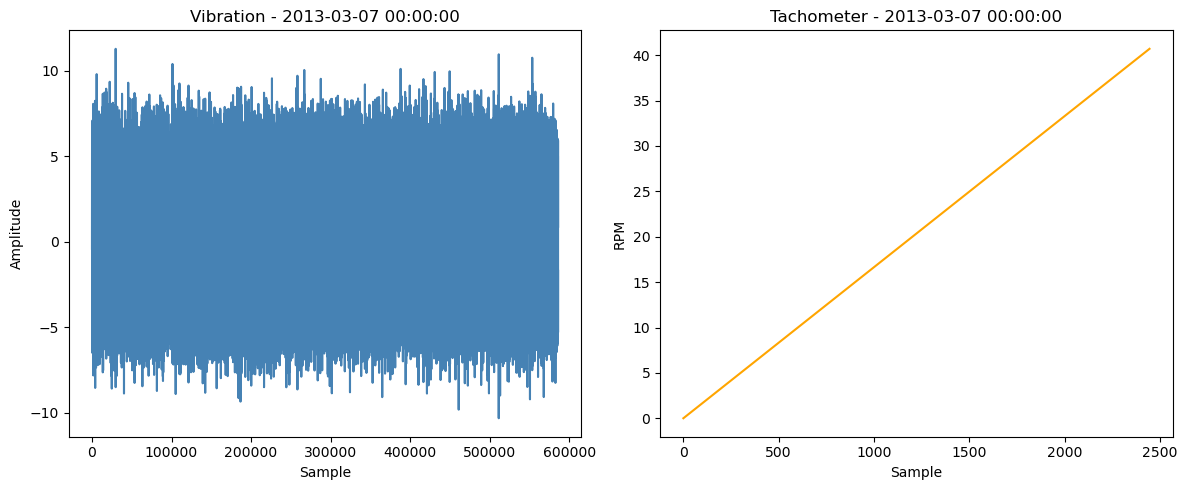

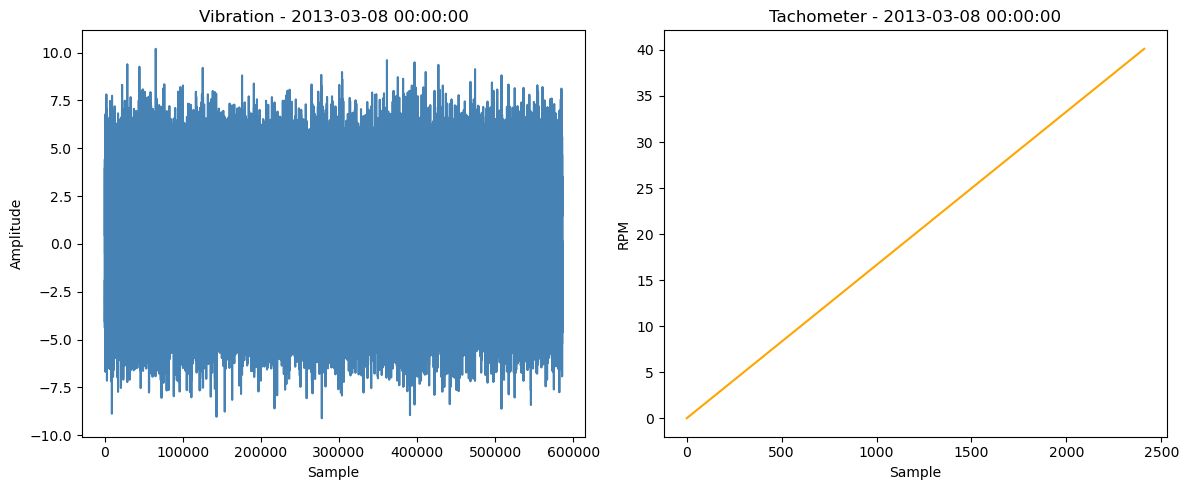

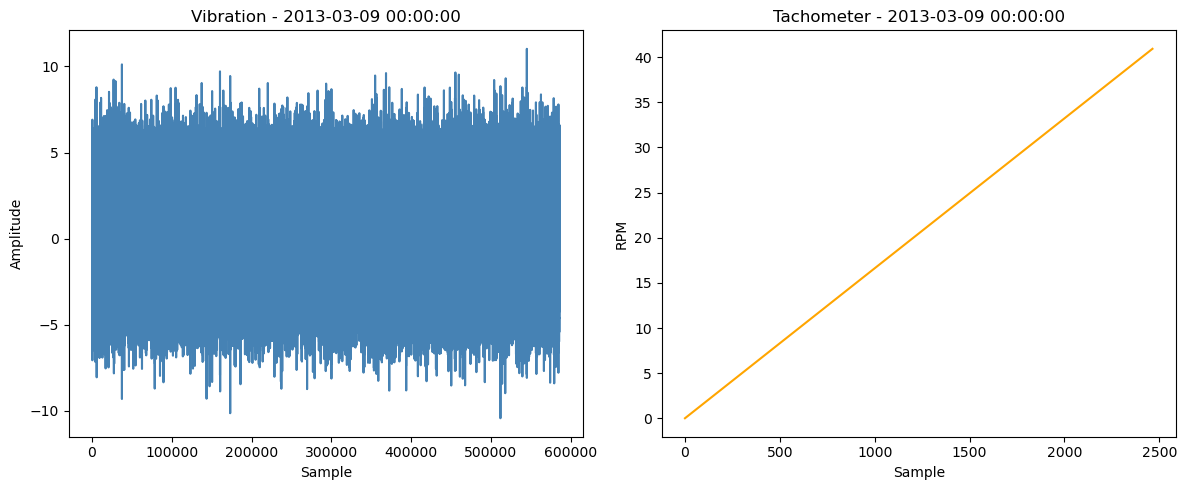

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set your folder path
folder_path = 'Bearing CSV'  # <-- Replace this with your actual folder path

# Get all files in the folder
all_files = os.listdir(folder_path)

# Separate vibration and tach files
vibration_files = sorted([f for f in all_files if f.endswith('vibration.csv')])
tach_files = sorted([f for f in all_files if f.endswith('tach.csv')])

# Ensure matching vibration-tach pairs
paired_files = []
for vib_file in vibration_files:
    base_name = vib_file.replace('_vibration.csv', '')
    corresponding_tach = f"{base_name}_tach.csv"
    if corresponding_tach in tach_files:
        paired_files.append((vib_file, corresponding_tach))

dates = pd.date_range(start="2013-03-07", end="2013-04-25", freq="D")

# Plot a few file pairs (e.g., 3)
# for i, (vib_file, tach_file) in enumerate(paired_files[:3]):
for date, (vib_file, tach_file) in zip(dates[:3], paired_files[:3]):

    vib_path = os.path.join(folder_path, vib_file)
    tach_path = os.path.join(folder_path, tach_file)
    
    # Load data
    vib_data = pd.read_csv(vib_path, header=None)
    tach_data = pd.read_csv(tach_path, header=None)
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(vib_data, color='steelblue')
    plt.title(f'Vibration - {date}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    plt.plot(tach_data, color='orange')
    plt.title(f'Tachometer - {date}')
    plt.xlabel('Sample')
    plt.ylabel('RPM')
    
    plt.tight_layout()
    plt.show()


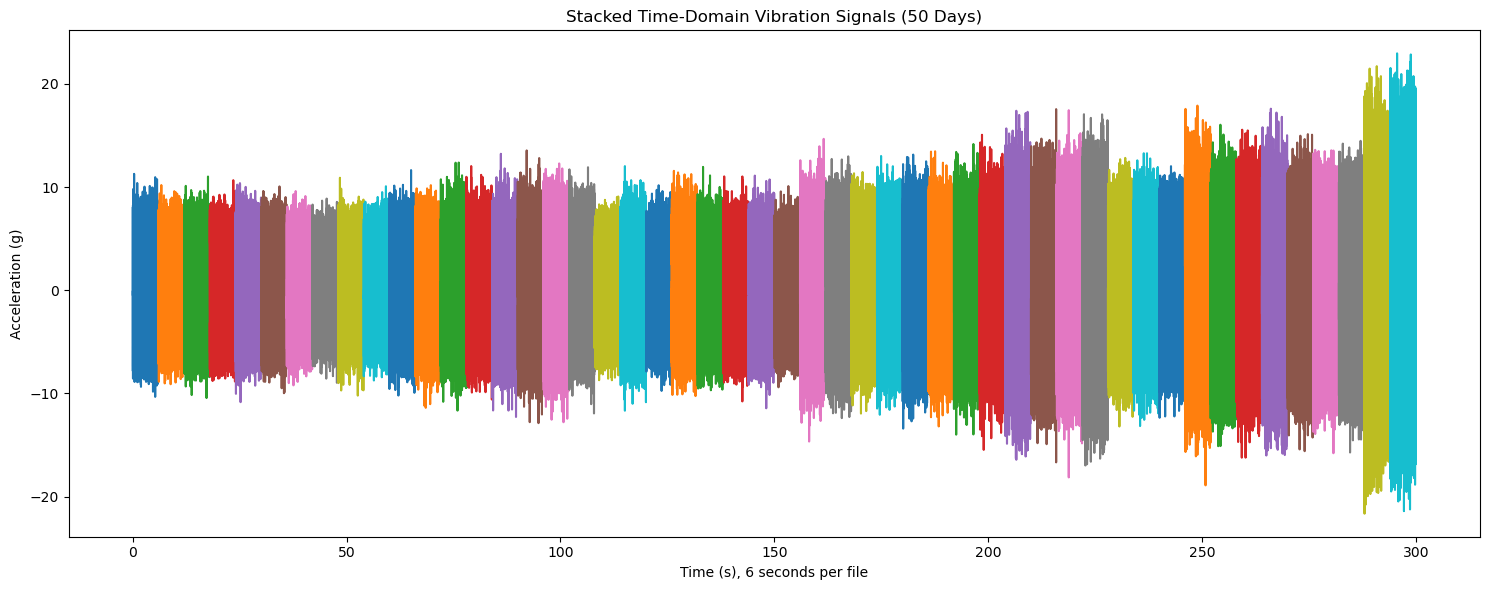

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
fs = 97656  # Replace with actual sampling rate (Hz)
tstart = 0
downsample_factor = 1

# Generate dates from March 7 to May 2
dates = pd.date_range(start="2013-03-07", end="2013-04-25", freq="D")

plt.figure(figsize=(15, 6))
for date, file in zip(dates, vibration_files):
    vib_path = os.path.join(folder_path, file)
    v = pd.read_csv(vib_path, header=None).squeeze()
    t = tstart + np.arange(len(v)) / fs
    plt.plot(t, v, label=date.strftime("%Y-%m-%d"))
    tstart = t[-1]

plt.xlabel("Time (s), 6 seconds per file")
plt.ylabel("Acceleration (g)")
plt.title("Stacked Time-Domain Vibration Signals (50 Days)")
# plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.tight_layout()
plt.show()


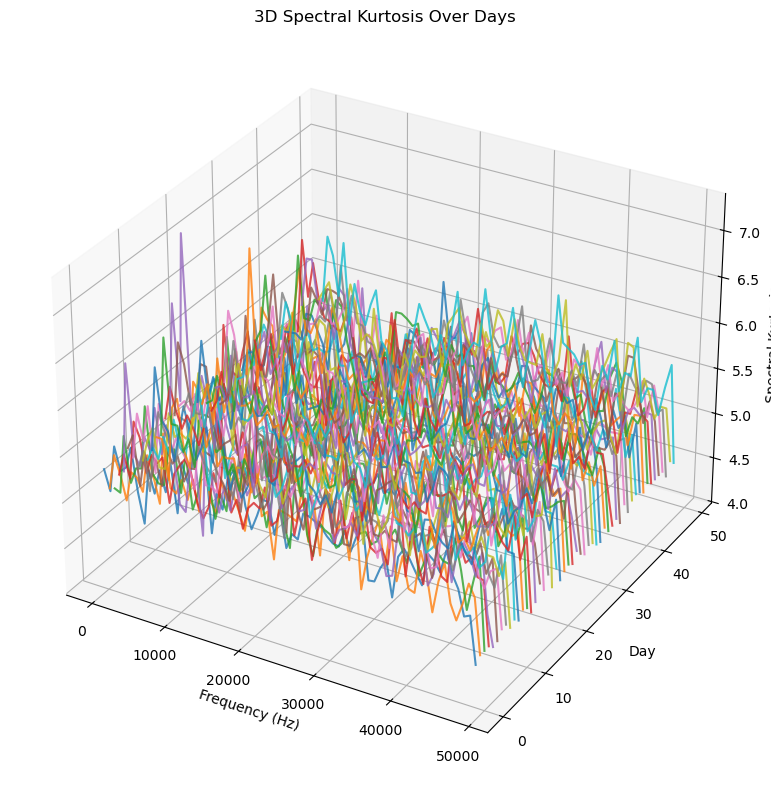

In [3]:
import numpy as np
import pandas as pd
import os
from scipy.signal import spectrogram, stft
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def pkurtosis(x, fs=1.0, window=128, nfft=None):
    """
    Python equivalent of MATLAB's pkurtosis.
    Computes the spectral kurtosis of a 1D signal using STFT.

    Returns:
    - sk: 1D array of spectral kurtosis per frequency bin
    - f: frequency vector
    """
    if nfft is None:
        nfft = window
    noverlap = int(0.8 * window)

    f, t, Sxx = spectrogram(
        x, fs=fs, nperseg=window, noverlap=noverlap,
        nfft=nfft, scaling='density', mode='psd'
    )

    Sxx = np.log(Sxx + 1e-10)  # Avoid log(0)

    sk = kurtosis(Sxx, axis=1, fisher=False)
    return sk, f

window = 128

# For plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

feature_list = []

for day, file in enumerate(vibration_files):
    filepath = os.path.join(folder_path, file)
    v = pd.read_csv(filepath, header=None).squeeze().values

    # --- Spectral Kurtosis ---
    SK, freq = pkurtosis(v, fs=fs, window=window)

    # 3D Plot of SK
    ax.plot(freq, SK, zs=day, zdir='y', alpha=0.8)

    # --- Time-Domain Features ---
    mean_ = np.mean(v)
    std_ = np.std(v)
    skew_ = skew(v)
    kurt_ = kurtosis(v, fisher=False)
    peak2peak_ = np.ptp(v)
    rms_ = np.sqrt(np.mean(v**2))
    crest = np.max(np.abs(v)) / rms_
    shape = rms_ / np.mean(np.abs(v))
    impulse = np.max(np.abs(v)) / np.mean(np.abs(v))
    margin = np.max(np.abs(v)) / (np.mean(np.abs(v))**2)
    energy = np.sum(v**2)

    # --- Frequency-Domain Features (SK stats) ---
    sk_mean = np.mean(SK)
    sk_std = np.std(SK)
    sk_skew = skew(SK)
    sk_kurt = kurtosis(SK, fisher=False)

    # Append all features
    features = {
        'Mean': mean_,
        'Std': std_,
        'Skewness': skew_,
        'Kurtosis': kurt_,
        'Peak2Peak': peak2peak_,
        'RMS': rms_,
        'CrestFactor': crest,
        'ShapeFactor': shape,
        'ImpulseFactor': impulse,
        'MarginFactor': margin,
        'Energy': energy,
        'SKMean': sk_mean,
        'SKStd': sk_std,
        'SKSkewness': sk_skew,
        'SKKurtosis': sk_kurt
    }
    feature_list.append(features)

# --- Create DataFrame of Features ---
feature_df = pd.DataFrame(feature_list)
feature_df['Date'] = pd.date_range(start='2013-03-07', periods=len(feature_df), freq='D')
feature_df = feature_df.set_index('Date')

# --- 3D SK Plot Settings ---
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Day')
ax.set_zlabel('Spectral Kurtosis')
ax.set_title('3D Spectral Kurtosis Over Days')
plt.tight_layout()
plt.show()

# --- Optional: Save features for ML ---
feature_df.to_csv('bearing_features.csv', index=True)

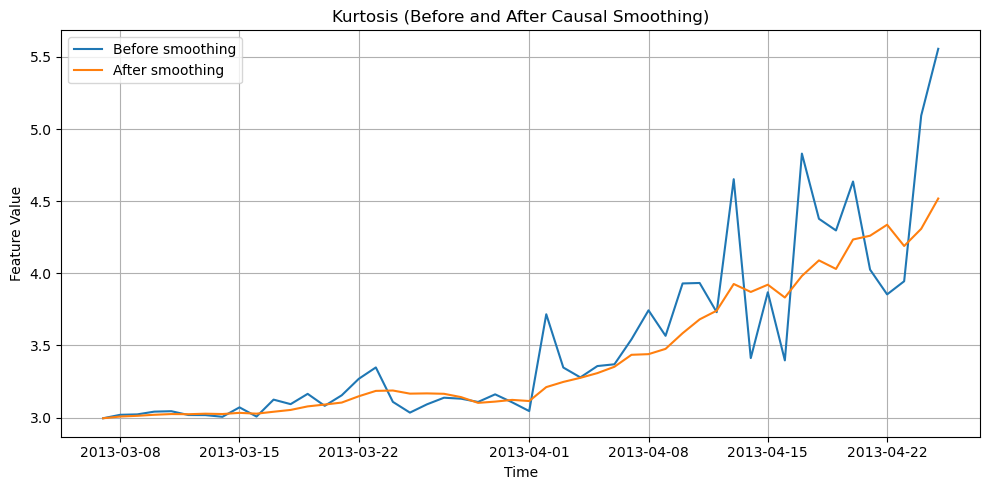

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume feature_df is already created and indexed by date or file order
# Apply causal moving average smoothing (window = 6: 5 past + current)
feature_df_smooth = feature_df.rolling(window=6, min_periods=1).mean()

feature = 'Kurtosis'

# Plot example: SKMean before and after smoothing
plt.figure(figsize=(10, 5))
plt.plot(dates, feature_df[feature], label='Before smoothing')
plt.plot(dates, feature_df_smooth[feature], label='After smoothing')
plt.xlabel('Time')
plt.ylabel('Feature Value')
plt.title(f'{feature} (Before and After Causal Smoothing)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
train_df = feature_df_smooth.iloc[:20].copy()

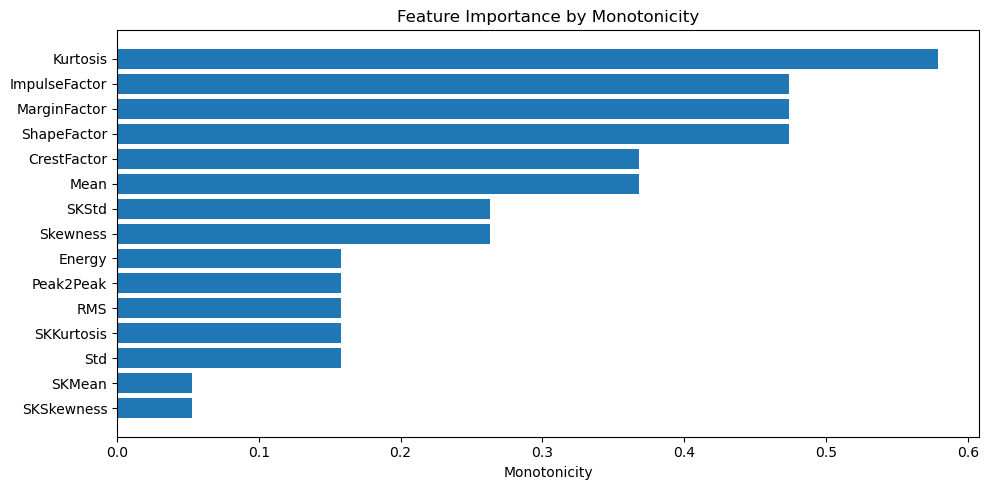

In [6]:
def compute_monotonicity(series):
    diffs = np.diff(series.values)
    pos = np.sum(diffs > 0)
    neg = np.sum(diffs < 0)
    return np.abs(pos - neg) / (len(series) - 1)

# Apply to all columns (excluding 'Date')
feature_cols = train_df.columns.difference(['Date'])
monotonicity_scores = train_df[feature_cols].apply(compute_monotonicity)

# Convert to DataFrame for easier filtering
monotonicity_df = pd.DataFrame({'Feature': monotonicity_scores.index, 'Monotonicity': monotonicity_scores.values})
monotonicity_df = monotonicity_df.sort_values(by='Monotonicity', ascending=False)

# Plot (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.barh(monotonicity_df['Feature'], monotonicity_df['Monotonicity'])
plt.xlabel('Monotonicity')
plt.title('Feature Importance by Monotonicity')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [7]:
important_features = monotonicity_df[monotonicity_df['Monotonicity'] > 0.3]['Feature'].tolist()

# For training
train_selected = train_df[important_features]

# For full dataset (optional)
feature_selected = feature_df_smooth[important_features]


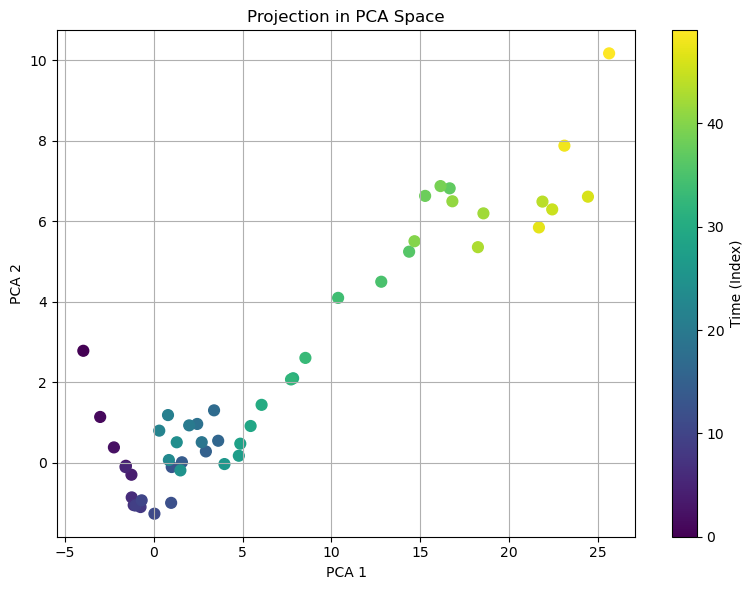

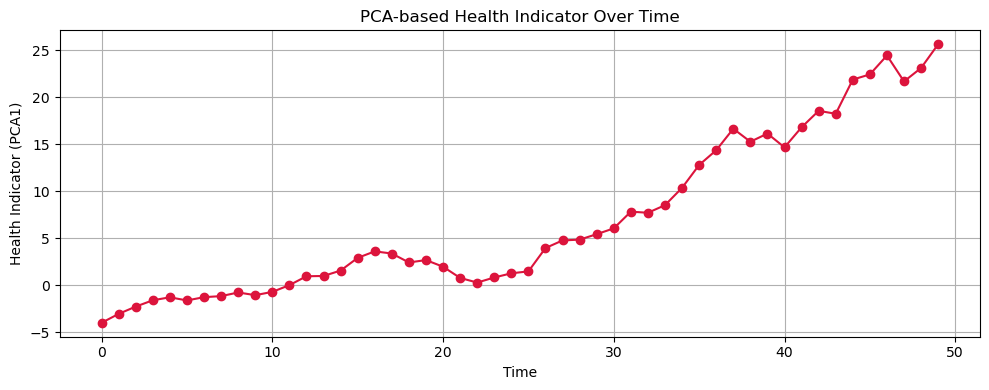

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----- Step 1: Use trainSelected and featureSelected -----
# Assume train_selected (first 20 days) and feature_selected (all 50 days)
# Already created and contain only the selected features (columns), not Date

# Step 2: Normalize training features
mean_train = train_selected.mean()
std_train = train_selected.std()
train_normalized = (train_selected - mean_train) / std_train

# Step 3: Fit PCA on normalized training features
pca = PCA(n_components=2)
pca.fit(train_normalized)

# Step 4: Normalize full features using training mean/std, then apply PCA
feature_normalized = (feature_selected - mean_train) / std_train
pca_projection = pca.transform(feature_normalized)

PCA1 = pca_projection[:, 0]
PCA2 = pca_projection[:, 1]

# ----- Step 5: Plot PCA space -----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(PCA1, PCA2, c=np.arange(len(PCA1)), cmap='viridis', s=60)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
cbar = plt.colorbar(scatter)
cbar.set_label('Time (Index)')
plt.title('Projection in PCA Space')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Step 6: Health Indicator = PCA1 -----
health_indicator = PCA1

# Optional: if you have Date from original feature table
time_axis = feature_df_smooth['Date'] if 'Date' in feature_df_smooth.columns else np.arange(len(health_indicator))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, health_indicator, '-o', color='crimson')
plt.xlabel('Time')
plt.ylabel('Health Indicator (PCA1)')
plt.title('PCA-based Health Indicator Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()
 

In [9]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # ----- Step 1: Use trainSelected and featureSelected -----
# # Assume train_selected (first 20 days) and feature_selected (all 50 days)
# # Already created and contain only the selected features (columns), not Date

# # Step 2: Normalize training features
# mean_train = train_selected.mean()
# std_train = train_selected.std()
# train_normalized = (train_selected - mean_train) / std_train

# # Step 3: Fit PCA on normalized training features
# pca = PCA(n_components=5)
# pca.fit(train_normalized)

# # Step 4: Normalize full features using training mean/std, then apply PCA
# feature_normalized = (feature_selected - mean_train) / std_train
# pca_projection = pca.transform(feature_normalized)

# PCA1 = pca_projection[:, 0]
# PCA2 = pca_projection[:, 1]
# PCA3 = pca_projection[:, 4]

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(PCA1, PCA2, PCA3, c=np.arange(len(PCA1)), cmap='plasma', s=60)
# ax.set_xlabel('PCA 1')
# ax.set_ylabel('PCA 2')
# ax.set_zlabel('PCA 3')
# plt.title('PCA (3 Components)')
# plt.colorbar(sc, label='Time Index')
# plt.tight_layout()
# plt.show()


# # ----- Step 6: Health Indicator = PCA1 -----
# health_indicator = PCA1

# # Optional: if you have Date from original feature table
# time_axis = feature_df_smooth['Date'] if 'Date' in feature_df_smooth.columns else np.arange(len(health_indicator))

# plt.figure(figsize=(10, 4))
# plt.plot(time_axis, health_indicator, '-o', color='crimson')
# plt.xlabel('Time')
# plt.ylabel('Health Indicator (PCA1)')
# plt.title('PCA-based Health Indicator Over Time')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [10]:
health_indicator = health_indicator - health_indicator[0]
threshold = health_indicator[-1]  # Last point = failure

phi = -1  # intercept
theta_mean = 1
theta_var = 1e6
beta_mean = 1
beta_var = 1e6

sigma = 0.1 * threshold / (threshold - phi)
sigma2 = sigma ** 2


In [11]:
def generate_health_curve(phi, theta, beta, time, sigma):
    epsilon = np.random.normal(0, sigma, size=len(time))
    return phi + theta * np.exp(beta * time + epsilon - sigma**2 / 2)

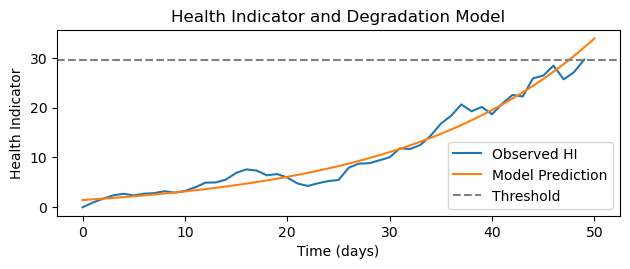

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

time_points = np.arange(len(health_indicator))
est_ruls = []
true_ruls = []
ci_ruls = []

# Prior parameters
phi = -1
theta_mu = 1
theta_var = 1e6
beta_mu = 1
beta_var = 1e6

sigma = 0.1 * threshold / (threshold - phi)
sigma2 = sigma ** 2

for t in range(len(health_indicator) - 1):
    ht = health_indicator[t]

    # Estimate beta and theta using linear regression in log-space
    if t >= 3:
        x = time_points[:t+1]
        y = np.log(np.maximum(health_indicator[:t+1] - phi, 1e-6))
        slope, intercept = np.polyfit(x, y, 1)
        beta_mu = slope
        theta_mu = np.exp(intercept)
    
    # Predict RUL: when will model reach threshold?
    future_time = np.linspace(0, 100, 1000)
    future_h = phi + theta_mu * np.exp(beta_mu * future_time)
    try:
        rul_est = future_time[np.argmax(future_h >= threshold)]
    except:
        rul_est = np.nan
    
    # Estimate confidence (±2σ using Gaussian assumption)
    ci_low = future_time[np.argmax(future_h >= threshold * 0.95)]
    ci_high = future_time[np.argmax(future_h >= threshold * 1.05)]

    est_ruls.append(rul_est)
    true_ruls.append(len(health_indicator) - t)
    ci_ruls.append((ci_low, ci_high))

# Adjust future_time to match the range of 0 to 50
future_time = np.linspace(0, 50, 1000)
future_h = phi + theta_mu * np.exp(beta_mu * future_time)

# Optional: plot live
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(time_points, health_indicator, label='Observed HI')
plt.plot(future_time, future_h, label='Model Prediction')
plt.axhline(threshold, color='gray', linestyle='--', label='Threshold')
# plt.fill_between(future_time, threshold * 0.95, threshold * 1.05, color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Health Indicator and Degradation Model')
plt.xlabel('Time (days)')
plt.ylabel('Health Indicator')
plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(50 - np.array(est_ruls), label='Estimated RUL')
# plt.plot(true_ruls, label='True RUL')
# plt.fill_between(range(len(est_ruls)), [50 - ci[0] for ci in ci_ruls], [50 - ci[1] for ci in ci_ruls], alpha=0.3, label='CI')
# plt.xlabel('Time (days)')
# plt.ylabel('RUL')
# plt.legend()

plt.tight_layout()
plt.show()

In [20]:
print("Model Prediction:")
print(phi + theta_mu * np.exp(beta_mu * time_points))

print("Observed HI:")
print(health_indicator)

print("Threshold:")
print((health_indicator > phi + theta_mu * np.exp(beta_mu * time_points)).astype(int))

# Convert the boolean array to a pandas DataFrame
result = pd.DataFrame((health_indicator > phi + theta_mu * np.exp(beta_mu * time_points)).astype(int), columns=['Condition'])
result.to_csv('health_indicator.csv', index=False)

Model Prediction:
[ 1.46169482  1.59573391  1.73707143  1.88610477  2.04325296  2.20895785
  2.38368537  2.56792678  2.76220013  2.96705165  3.18305731  3.41082447
  3.65099353  3.90423978  4.17127527  4.45285083  4.74975815  5.06283205
  5.3929528   5.7410486   6.10809819  6.49513361  6.90324308  7.33357407
  7.78733656  8.26580638  8.77032884  9.30232252  9.86328321 10.45478817
 11.07850053 11.73617398 12.4296577  13.16090156 13.93196159 14.74500579
 15.60232017 16.50631527 17.45953283 18.46465301 19.52450191 20.64205951
 21.82046803 23.06304081 24.37327159 25.75484433 27.21164361 28.74776549
 30.3675291  32.07548872]
Observed HI:
[ 0.          0.95041792  1.72330833  2.39700046  2.71069049  2.37792782
  2.72620691  2.83754375  3.22394704  2.93938995  3.28762587  4.0058817
  4.94865523  4.98067322  5.55619731  6.90583048  7.59874257  7.36616629
  6.4171363   6.67103167  5.96449011  4.77133765  4.27847486  4.82083165
  5.26338676  5.47002565  7.95222028  8.76149366  8.84469367  9.4260